In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go

import python_scripts.plotting as plotting

%matplotlib inline

## Initial Plots

In [2]:
# Selected columns of the cleaned dataframe
df_311_selection_path = "data/311_selected_columns.pkl"
# Assigns a label, an integer value, to each Complaint Type Class
path_ctc_legend = "complaint_type_cls_legend.json"
# Mapping from Complaint Types to Complaint Type Class labels
path_ctc = "complaint_type_cls.json"

In [14]:
with open(path_ctc_legend) as fp_legend:
    ct_legend = json.load(fp_legend)
with open(path_ctc) as fp_data:
    ct_data = json.load(fp_data)
    
ct_legend_inv = {v:k for k, v in ct_legend.items()}

In [6]:
df_311_raw = pd.read_pickle(df_311_selection_path)
df_311_raw["Created Year"] = df_311_raw["Created Date"].dt.year
df_311_raw.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Latitude,Longitude,Created Year
0,32438412,2016-01-17 22:12:35,2016-01-17 23:14:02,NYPD,New York City Police Department,Noise - Residential,40.861404,-73.903217,2016
1,32438413,2016-01-17 15:23:56,2016-01-17 19:28:40,NYPD,New York City Police Department,Noise - Residential,40.841828,-73.937822,2016
2,32438414,2016-01-17 19:04:42,2016-01-19 08:49:00,DOT,Department of Transportation,Street Condition,40.761218,-73.912766,2016
3,32438415,2016-01-17 18:46:31,2016-01-17 19:51:41,NYPD,New York City Police Department,Noise - Commercial,40.651177,-73.941618,2016
4,32438416,2016-01-18 00:02:23,2016-01-18 16:51:22,NYPD,New York City Police Department,Noise - Residential,40.636969,-73.958533,2016


As an initial step of our analysis, we would like to look at the distribution of 311 service requests over the years, to see if there is a trend.

In [7]:
yearly_complaints = df_311_raw.groupby("Created Year") \
                              .count()["Created Date"]

In [10]:
fig = go.Figure(
    data=go.Bar(
        x=yearly_complaints.keys(),
        y=yearly_complaints.values,
        marker=dict(
            color='rgb(250,128,114)',
            line=dict(
                color='rgb(8,48,107)',
                width=1.5),
        ),
        text=yearly_complaints.values,
        textposition = 'auto',
        opacity=0.6),
    layout_title_text="311 Service Requests per year" 
)
fig.update_layout(template="plotly_dark")
plotly.offline.plot(fig, filename='src/plots/complaints_per_year.html')

'src/plots/complaints_per_year.html'

It seems like there is a linear upward trend, which can probaly be explained by the increase in popularity of the service.

The wordcloud already provides a good picture of New York City's most prevalent problems, a closer look at the top-15 most frequent 311 requests is interesting nonetheless, as it shows the exact frequency of occurence of the respective requests:  

In [11]:
complaint_types = df_311_raw.groupby("Complaint Type") \
                            .count()["Created Date"] \
                            .rename(columns={"Created Date": "Number of complaints"}) \
                            .sort_values(ascending=False)[:15]

In [13]:
fig = go.Figure(
    data=go.Bar(
        x=complaint_types.values[:15],
        y=complaint_types.keys()[:15],
        orientation='h'),
    layout_title_text="Top-15 most frequent Complaint Types" 
)
fig.update_layout(template="plotly_dark")
plotly.offline.plot(fig, filename='plots/top_complaints.html')

'src/plots/top_complaints.html'

Before diving into a more detailed analysis, let's look at the distribution of **Complaint Type Categories** (CTC), after the labeling of Complaint Types was done in the initial processing of the dataset:

In [15]:
df_311_raw["Complaint Type Class Index"] = df_311_raw["Complaint Type"].apply(lambda k: ct_data[k] if k in ct_data else -1)
df_311_raw["Complaint Type Class"] = df_311_raw["Complaint Type Class Index"].apply(lambda k: ct_legend_inv[k])
# Complaint Type Class is a categorical variable, and can be converted in pandas for the sake of efficiency
df_311_raw["Complaint Type Class"] = df_311_raw["Complaint Type Class"].astype("category")

In [16]:
complaint_type_classes = df_311_raw.groupby("Complaint Type Class") \
                                   .count()["Created Date"] \
                                   .reset_index()

complaint_type_classes = complaint_type_classes.rename(columns={"Created Date": "Count"})

In [17]:
fig = go.Figure(
    data=go.Pie(
        values=complaint_type_classes['Count'],
        labels=complaint_type_classes['Complaint Type Class']
    ),
    layout_title_text="Distribution of Complaint Type Categories (CTC)" 
)
fig.update_layout(template="plotly_dark")
plotly.offline.plot(fig, filename='plots/complaint_type_categories.html')

'src/plots/complaint_type_categories.html'

## Ranking NTAs

There exist several ways to split a city in meaningful ways. Blocks, districts, boroughs,... But in New York City, it's interesting to consider Neighborhood Tabulation Areas (formerly "Neighborhood Projection Areas"), or simply NTAs.

According to NYC official website: _[NTAs] were created to project populations at a small area level, from 2000 to 2030 for PlaNYC, the long-term sustainability plan for New York City. Since population size affects the error associated with population projections, these geographic units needed to have a minimum population, which we determined to be 15,000. This criterion resulted in combinations of neighborhoods that probably would not occur if one were solely designating boundaries of historical neighborhoods._

It becomes interesting to compare NTAs between them with an innovative criterion: the number of requests made concerning each of them. With that, and because they have a relatively similar count of inhabitants, we are able to "rank" them according to certain criterions. With that, we could help recommend arriving citizens some favorable places according to their preferences: if noise is a real problem for them, we would recommend them not to settle in a place with many requests linked to noise. We have access to the population data of the NTAs (2010 census), which will allow us to construct a better ranking scheme that normalizes the number of complaints by the population size of the NTA.

In [2]:
# Selected columns, NTA associated to a 311 requests was added through an external script
cleaned_311_path = "data/NTA_and_CTC_output.pkl"
# NTA geojson, used to locate NTAs and the borders between them
nta_path = "data/Neighborhood Tabulation Areas.geojson"
# 2010 census: population of the NTAs
nta_population_path = "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv"

In [3]:
nta_pop_df = pd.read_csv(nta_population_path)

In [4]:
df_311 = pd.read_pickle(cleaned_311_path)
df_311["Complaint Type Class"] = df_311["Complaint Type Class"].astype("category")
df_311.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Latitude,Longitude,Complaint Type Class Index,Complaint Type Class,NTA
Unique Key,,,,,,,,,,
32438412,2016-01-17 22:12:35,2016-01-17 23:14:02,NYPD,New York City Police Department,Noise - Residential,40.861404,-73.903217,0,noise annoyance,BX30
32438413,2016-01-17 15:23:56,2016-01-17 19:28:40,NYPD,New York City Police Department,Noise - Residential,40.841828,-73.937822,0,noise annoyance,MN36
32438414,2016-01-17 19:04:42,2016-01-19 08:49:00,DOT,Department of Transportation,Street Condition,40.761218,-73.912766,2,public utility condition,QN70
32438415,2016-01-17 18:46:31,2016-01-17 19:51:41,NYPD,New York City Police Department,Noise - Commercial,40.651177,-73.941618,0,noise annoyance,BK91
32438416,2016-01-18 00:02:23,2016-01-18 16:51:22,NYPD,New York City Police Department,Noise - Residential,40.636969,-73.958533,0,noise annoyance,BK42


In [5]:
# Add columns for date, weekday and hour of creation
df_311["Created Year"] = df_311["Created Date"].dt.year
df_311["Created Day"] = df_311["Created Date"].dt.date
df_311["Created Hour"] = df_311["Created Date"].dt.hour
df_311["Created Weekday"] = df_311["Created Date"].dt.dayofweek

df_311.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Latitude,Longitude,Complaint Type Class Index,Complaint Type Class,NTA,Created Year,Created Day,Created Hour,Created Weekday
Unique Key,,,,,,,,,,,,,,
32438412,2016-01-17 22:12:35,2016-01-17 23:14:02,NYPD,New York City Police Department,Noise - Residential,40.861404,-73.903217,0,noise annoyance,BX30,2016,2016-01-17,22,6
32438413,2016-01-17 15:23:56,2016-01-17 19:28:40,NYPD,New York City Police Department,Noise - Residential,40.841828,-73.937822,0,noise annoyance,MN36,2016,2016-01-17,15,6
32438414,2016-01-17 19:04:42,2016-01-19 08:49:00,DOT,Department of Transportation,Street Condition,40.761218,-73.912766,2,public utility condition,QN70,2016,2016-01-17,19,6
32438415,2016-01-17 18:46:31,2016-01-17 19:51:41,NYPD,New York City Police Department,Noise - Commercial,40.651177,-73.941618,0,noise annoyance,BK91,2016,2016-01-17,18,6
32438416,2016-01-18 00:02:23,2016-01-18 16:51:22,NYPD,New York City Police Department,Noise - Residential,40.636969,-73.958533,0,noise annoyance,BK42,2016,2016-01-18,0,0


### Neighborhood Tabulation Areas (NTAs)

We will use NTA population sizes to normalize the number of 311 requests, which will lead to a better ranking scheme.

In [6]:
# Using the latest census to estimate population size of an NTA
nta_pop_df = nta_pop_df[nta_pop_df["Year"] == 2010][["NTA Code", "NTA Name", "Population"]].set_index("NTA Code")

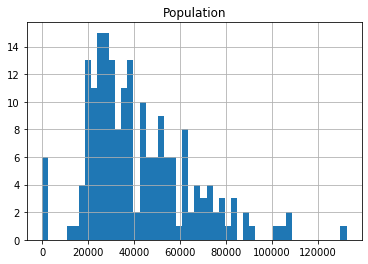

In [7]:
nta_pop_df.hist(bins=50);

There seem to be some outliers, some NTAs have a very small population and should be invastigated before appearing in a ranking of the NTAs. A cutoff with respect to the population size should reveal the 6 outliers:

In [8]:
threshold = 10000

In [9]:
nta_pop_df[nta_pop_df.Population < threshold].sort_values("Population")

,NTA Name,Population
NTA Code,,
QN98,Airport,0
SI99,park-cemetery-etc-Staten Island,0
BK99,park-cemetery-etc-Brooklyn,418
QN99,park-cemetery-etc-Queens,436
MN99,park-cemetery-etc-Manhattan,1849
BX99,park-cemetery-etc-Bronx,1906


The NTAs above are an airport / parks and cemeteries, which explains the small population sizes.

In [10]:
nta_pop_df[nta_pop_df.Population > threshold].sort_values("Population")

,NTA Name,Population
NTA Code,,
BX98,Rikers Island,11091
BK93,Starrett City,13354
SI14,Grasmere-Arrochar-Ft. Wadsworth,16079
SI35,New Brighton-Silver Lake,17525
BK23,West Brighton,17750
...,...,...
BK61,Crown Heights North,103169
BK42,Flatbush,105804
BK88,Borough Park,106357


We decided not to consider in our analysis the NTAs that have a population size smaller than 10.000, hence to drop the corresponding complaints, as the population size and nature of the concerned NTAs would most likely result in a misinterpretation of our ranking.

In [11]:
invalid_ntas = nta_pop_df[nta_pop_df.Population < threshold].index.tolist()
df_311 = df_311[~df_311.NTA.isin(invalid_ntas)]

### Ranking

In [12]:
nta_complaints = df_311.groupby("NTA") \
                       .count()["Created Date"] \
                       .reset_index() \
                       .rename(columns={"Created Date": "Number of complaints"})

A naive ranking would only look at the number of complaints per NTA. Since we have access to population sizes, a more sensible ranking scheme takes into account the population size of an NTA.

In [13]:
nta_complaints = nta_complaints.merge(nta_pop_df, left_on="NTA", right_index=True).set_index("NTA")
nta_complaints["Complaints per 1k capita"] = 1000 * nta_complaints["Number of complaints"] / nta_complaints["Population"]
nta_complaints["Number of complaints rank"] = nta_complaints["Number of complaints"].rank(method="first")
nta_complaints["Complaints per 1k capita rank"] = nta_complaints["Complaints per 1k capita"].rank(method="first")
nta_complaints = nta_complaints.sort_values(by="Complaints per 1k capita rank")
nta_complaints.head(15)

,Number of complaints,NTA Name,Population,Complaints per 1k capita,Number of complaints rank,Complaints per 1k capita rank
NTA,,,,,,
BX98,172,Rikers Island,11091,15.508070,1.0,1.0
MN50,11266,Stuyvesant Town-Cooper Village,21049,535.227327,3.0,2.0
BK93,8148,Starrett City,13354,610.154261,2.0,3.0
BK23,11575,West Brighton,17750,652.112676,4.0,4.0
BX13,33298,Co-Op City,43752,761.062351,9.0,5.0
BK72,32880,Williamsburg,32926,998.602928,8.0,6.0
QN47,27031,Ft. Totten-Bay Terrace-Clearview,21751,1242.747460,5.0,7.0
MN31,100404,Lenox Hill-Roosevelt Island,80771,1243.069914,112.0,8.0
BX46,37322,Parkchester,29821,1251.534154,12.0,9.0


In [14]:
columns = ["NTA Name", "Population", "Number of complaints", "Complaints per 1k capita rank", "Number of complaints rank"]

fig = go.Figure(data=[go.Table(
    columnwidth=40,
    header=dict(values=columns,
                fill_color='rgb(250,128,114)',
                font=dict(color='black'),
                align='center'),
    cells=dict(values=nta_complaints[columns].head(12).to_numpy().T,
               fill_color='gray',
               align=['center', 'left'],
               height=30))
],
               layout_title_text="Ranking of NTAs based on number of complaints per capita")

fig.update_layout(template="plotly_dark")
plotly.offline.plot(fig, filename='plots/nta_ranking.html')

'plots/nta_ranking.html'

One NTA really stands out, both in terms of total complaints and complaints per capita: _Rikers Island_. This example highlights the fact that no ranking is perfect and should therefore be taken with a grain of salt, we would not recommend moving to that island as it is _a 1.67 km2 island in the East River between Queens and the Bronx that is home to New York City's main jail complex_. 

Interesting fact about  _Stuyvesant Town-Cooper Village_ and _Starrett City_: both NTAs have their own public safety forces, which might explain why they have so few complaints per capita. In fact, _Starrett City_ had one of the city's lowest crime rates, mainly because of the existence of the security force. This private security force has been used as a case study in the advantages of private security over public policing.

### Evolution of complaints per capita

We might also want to take a look at possible improvements in NTAs over the years, if for instance a specific problem has been tackled by the local authorities. Because of the upward trend of the 311 service requests, we cannot just look at the total number of complaints per year per year, but should rather check how the number of complaints per capita compare to the city-wide average per year.

In [15]:
yearly_complaints = df_311.groupby("Created Year") \
                          .count()["Created Date"] \
                          .reset_index() \
                          .rename(columns={"Created Date": "Yearly complaints"})

total_population = nta_pop_df.Population.sum()
yearly_complaints["Yearly complaints per 1k capita"] = 1000 * yearly_complaints["Yearly complaints"] / total_population

In [16]:
nta_yearly_complaints = df_311.groupby(["NTA", "Created Year"]) \
                              .count()["Created Date"] \
                              .reset_index() \
                              .rename(columns={"Created Date": "Total complaints"})
nta_yearly_complaints = nta_yearly_complaints.merge(yearly_complaints, on="Created Year")
nta_yearly_complaints = nta_yearly_complaints.merge(nta_pop_df, left_on="NTA", right_index=True)
nta_yearly_complaints.head()

,NTA,Created Year,Total complaints,Yearly complaints,Yearly complaints per 1k capita,NTA Name,Population
0,BK09,2010,3535,1768271,216.298744,Brooklyn Heights-Cobble Hill,22887
189,BK09,2011,3331,1698959,207.820350,Brooklyn Heights-Cobble Hill,22887
378,BK09,2012,3559,1579302,193.183646,Brooklyn Heights-Cobble Hill,22887
567,BK09,2013,3440,1607373,196.617352,Brooklyn Heights-Cobble Hill,22887
756,BK09,2014,4287,1897801,232.143135,Brooklyn Heights-Cobble Hill,22887


In [17]:
nta_yearly_complaints["Complaints per 1k capita"] = 1000 * nta_yearly_complaints["Total complaints"] / nta_yearly_complaints["Population"]
nta_yearly_complaints["Factor"] = nta_yearly_complaints["Complaints per 1k capita"] / nta_yearly_complaints["Yearly complaints per 1k capita"]
nta_yearly_complaints.sort_values(by="Factor", ascending=False)

,NTA,Created Year,Total complaints,Yearly complaints,Yearly complaints per 1k capita,NTA Name,Population,Complaints per 1k capita,Factor
1231,MN17,2016,30074,2171216,265.587850,Midtown-Midtown South,28630,1050.436605,3.955138
664,MN17,2013,18069,1607373,196.617352,Midtown-Midtown South,28630,631.121202,3.209896
1420,MN17,2017,24711,2274438,278.214189,Midtown-Midtown South,28630,863.115613,3.102342
475,MN17,2012,16948,1579302,193.183646,Midtown-Midtown South,28630,591.966469,3.064268
1798,MN17,2019,20129,1931377,236.250224,Midtown-Midtown South,28630,703.073699,2.975971
...,...,...,...,...,...,...,...,...,...
86,BX98,2010,10,1768271,216.298744,Rikers Island,11091,0.901632,0.004168
1031,BX98,2015,11,2062860,252.333509,Rikers Island,11091,0.991795,0.003930
275,BX98,2011,8,1698959,207.820350,Rikers Island,11091,0.721306,0.003471
653,BX98,2013,7,1607373,196.617352,Rikers Island,11091,0.631142,0.003210


In [20]:
path_nta = "data/Neighborhood Tabulation Areas.geojson"

with open(path_nta) as f:
    geojson = json.load(f)

features = plotting.get_features(nta_yearly_complaints, geojson, df_area_key="NTA", df_year_key="Created Year", gj_area_key="ntacode",
                        relevant_feature="Factor")

m = plotting.map_features(features)
m.save("maps/nta_factors.html")

### Comparison of selected NTAs

Finally, while a general rankinkg that looks at all types of complaints certainly is helpful, people have different preferences when it comes to choosing a place to live. For instance one might not care about the fact that there are frequently problems with the infractructure of a neighborhood (brooken streetlight, graffitis on the walls, but be very sensitive to noise. This is why we now take a closer look at a selection of NTAs, that already have the lowest number of complaints per capita, but distinguish between different Complaint Categegory Classes (CTCs), to see how the NTAs perform in each category, with respect to the city-wide average. 

In [21]:
complaint_type_classes = df_311.groupby("Complaint Type Class") \
                               .count()["Created Date"] \
                               .sort_values(ascending=False)

complaint_type_classes

Complaint Type Class
private property condition               7160626
public utility condition                 3955732
noise annoyance                          3791741
human activity disturbance               3607766
general/miscellaneous                     669524
pest                                      307687
unclassified                               18098
taxation or advantage program related      15461
Name: Created Date, dtype: int64

Here we only focus on the top-4 complaints, because they contribute most to the total number of complaints and are particularly relevant for most people that decide whether or not to move to a certain neighborhood.

In [22]:
selected_classes = complaint_type_classes.index.tolist()[:4]
complaint_type_classes = complaint_type_classes[selected_classes].reset_index() \
                                                                 .rename(columns={"Created Date": "Count"})
complaint_type_classes["Class complaints per 1k capita"] = 1000 * complaint_type_classes["Count"] / total_population
complaint_type_classes.head()

,Complaint Type Class,Count,Class complaints per 1k capita
0,private property condition,7160626,875.903303
1,public utility condition,3955732,483.873718
2,noise annoyance,3791741,463.813983
3,human activity disturbance,3607766,441.309762


In [23]:
nta_complaints_per_class = df_311[df_311["Complaint Type Class"].isin(selected_classes)] \
                                 .groupby(["NTA", "Complaint Type Class"]) \
                                 .count()["Created Date"] \
                                 .reset_index() \
                                 .rename(columns={"Created Date": "Number of complaints"}) \
                                 .dropna()

nta_complaints_per_class.head()

,NTA,Complaint Type Class,Number of complaints
1,BK09,human activity disturbance,9175.0
2,BK09,noise annoyance,9364.0
4,BK09,private property condition,10792.0
5,BK09,public utility condition,13138.0
9,BK17,human activity disturbance,28217.0


In [24]:
nta_complaints_per_class = nta_complaints_per_class.merge(nta_pop_df, left_on="NTA", right_index=True)
nta_complaints_per_class = nta_complaints_per_class.merge(complaint_type_classes, on="Complaint Type Class")
nta_complaints_per_class["NTA complaints per 1k capita"] = 1000 * nta_complaints_per_class["Number of complaints"] / nta_complaints_per_class["Population"]
nta_complaints_per_class["Factor"] = nta_complaints_per_class["NTA complaints per 1k capita"] / nta_complaints_per_class["Class complaints per 1k capita"]
nta_complaints_per_class.head()

,NTA,Complaint Type Class,Number of complaints,NTA Name,Population,Count,Class complaints per 1k capita,NTA complaints per 1k capita,Factor
0,BK09,human activity disturbance,9175.0,Brooklyn Heights-Cobble Hill,22887,3607766,441.309762,400.882597,0.908393
1,BK17,human activity disturbance,28217.0,Sheepshead Bay-Gerritsen Beach-Manhattn Bch,64518,3607766,441.309762,437.350817,0.991029
2,BK19,human activity disturbance,13974.0,Brighton Beach,35547,3607766,441.309762,393.113343,0.890788
3,BK21,human activity disturbance,7670.0,Seagate-Coney Island,31965,3607766,441.309762,239.949945,0.543722
4,BK23,human activity disturbance,1777.0,West Brighton,17750,3607766,441.309762,100.112676,0.226854


In [25]:
factor_table = nta_complaints_per_class.pivot(index="NTA Name", columns="Complaint Type Class", values="Factor")
factor_table.head()

Complaint Type Class,human activity disturbance,noise annoyance,private property condition,public utility condition
NTA Name,,,,
Allerton-Pelham Gardens,0.903790,0.530748,0.573150,1.383371
Annadale-Huguenot-Prince's Bay-Eltingville,1.024547,0.248523,0.537991,2.217728
Arden Heights,1.003791,0.199219,0.388853,1.459384
Astoria,1.160815,1.017286,0.676997,0.928609
Auburndale,1.219456,0.254679,0.464128,2.034099


In [26]:
selected_ntas = nta_complaints["NTA Name"].values.tolist()[1:21]
selected_factors = factor_table.loc[selected_ntas]
complaint_factors = selected_factors.to_numpy().T

In [28]:
fig = go.Figure(
    data=go.Heatmap(
        z=complaint_factors,
        x=selected_ntas,
        y=selected_classes,
        colorscale='Viridis')
    )
fig.update_layout(title="Counts per capita scaling factor (vs city-wide average) of selected NTAs", template="plotly_dark")
fig.update_xaxes(tickangle=45)
plotly.offline.plot(fig, filename='plots/nta_heatmap.html')

'plots/nta_heatmap.html'